<a href="https://colab.research.google.com/github/mohiiieldin/Predict-Future-Sales-Competition-on-Kaggle/blob/master/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from datetime import datetime, timedelta,date
import seaborn as sns
from sklearn.metrics import mean_squared_error
#importing machine learning libraries
import pickle
import gc # to free some space from the memory
from sklearn.model_selection import KFold


#importing regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

#ignoring warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

# time seires staff
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

plt.style.use('ggplot') # plots style
# fixing the seed so that the code is reproduceable
random_state = 1

In [0]:
# Reading Data
item_categories = pd.read_csv("/content/drive/My Drive/GP Data/item_categories-translated.csv") 
items = pd.read_csv("/content/drive/My Drive/GP Data/items-translated.csv")
sales = pd.read_csv("/content/drive/My Drive/GP Data/sales_train_v2.csv")
shops = pd.read_csv("/content/drive/My Drive/GP Data/shops-translated.csv")
test = pd.read_csv("/content/drive/My Drive/GP Data/test.csv")
sample_submission = pd.read_csv('/content/drive/My Drive/GP Data/sample_submission.csv')

Let's take a look on the data

In [0]:
print("----------Shape of Data----------")
print(sales.shape)
print("----------first 5 rows----------")
print(sales.head(5))
print("-----------data frame overview-----------")
print(sales.info())
print("----------Missing value-----------")
print(sales.isnull().sum())

----------Shape of Data----------
(2935849, 6)
----------first 5 rows----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------data frame overview-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------Missing val

1) Date 

In [0]:
# changing the type of the column into date time, this will ease future feature engineering
sales.date = pd.to_datetime(sales.date)
print("First date --> " , sales.date.min())
print("Last date --> " , sales.date.max())

First date -->  2013-01-01 00:00:00
Last date -->  2015-12-10 00:00:00


2) date_block_num

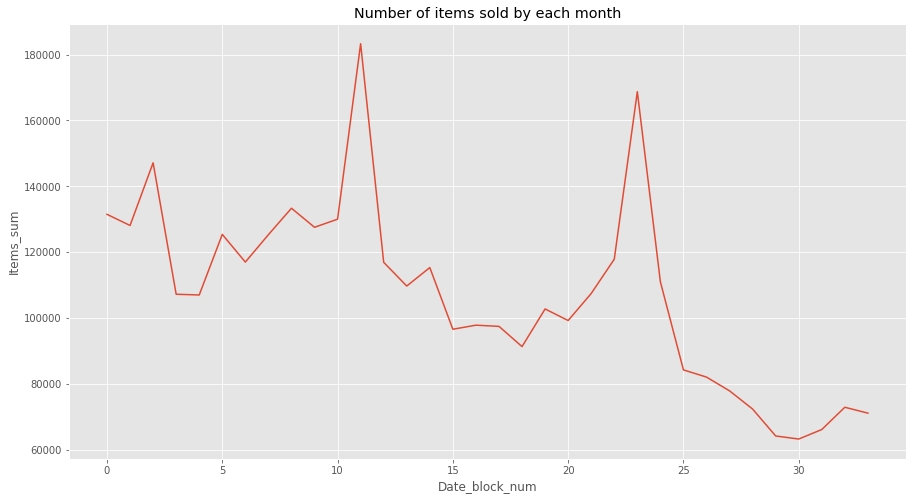

In [0]:
#what is the number of items soled at each month ?
sales_grouped_by_month =  sales.groupby('date_block_num')['item_cnt_day'].sum()
plt.figure(figsize=(15,8))
plt.title("Number of items sold by each month")
plt.xlabel("Date_block_num")
plt.ylabel("Items_sum")
sns.lineplot(data = sales_grouped_by_month)

3) shop_id

In [0]:
print("Nuumber of shops is : ",sales.shop_id.nunique())

Nuumber of shops is :  60


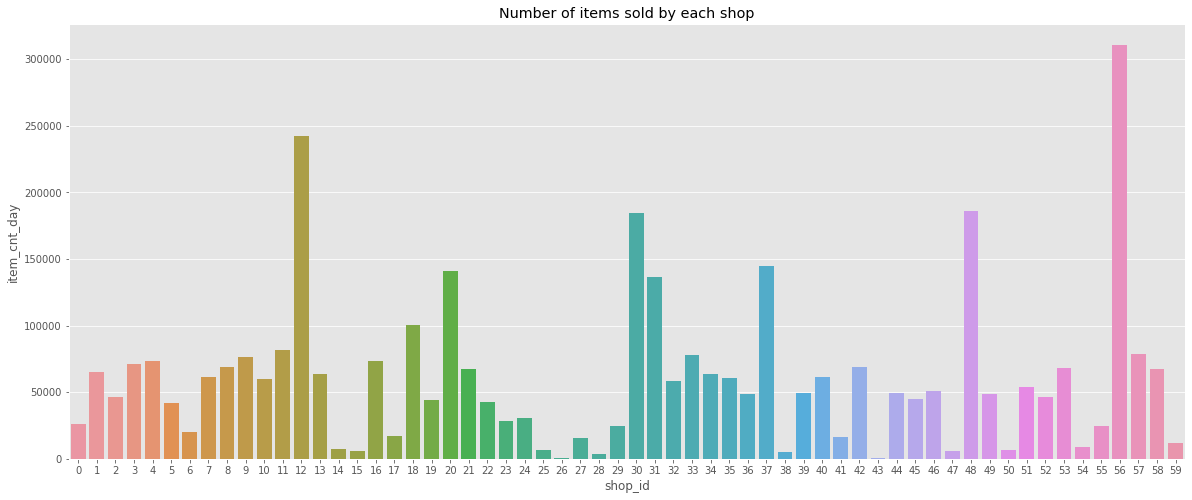

In [0]:
# what is the number of items soled at each shop ?
items_ordered_grouped_by_shop =  sales.groupby('shop_id')['item_cnt_day'].sum()
plt.figure(figsize=(20,8))
plt.title("Number of items sold by each shop")
plt.xlabel("shop_id")
plt.ylabel("Items_mean")
sns.barplot(x = sales.shop_id.unique(),y =  items_ordered_grouped_by_shop )

There is a significant difference between the shops in terms number of ordered items.

4) item_id

In [0]:
#number of unique items
print(sales.item_id.nunique())
best_5_items = sales.groupby("item_id")['item_cnt_day'].sum().sort_values(ascending = False ).head(5)
items_info = items[items.item_id.isin(best_5_items.index)].sort_values(by = 'item_id')
items_info

21807


,item_id,item_category_id,item_name_translated
2808,2808,30,"Diablo III [PC, Jewel, Russian version]"
3732,3732,19,"Grand Theft Auto V [PS3, Russian subtitles]"
5822,5822,35,Playstation Store replenishment of wallet: Pay...
17717,17717,79,Acceptance of funds for 1C-Online
20949,20949,71,Corporate package T-shirt 1C Interest white (3...


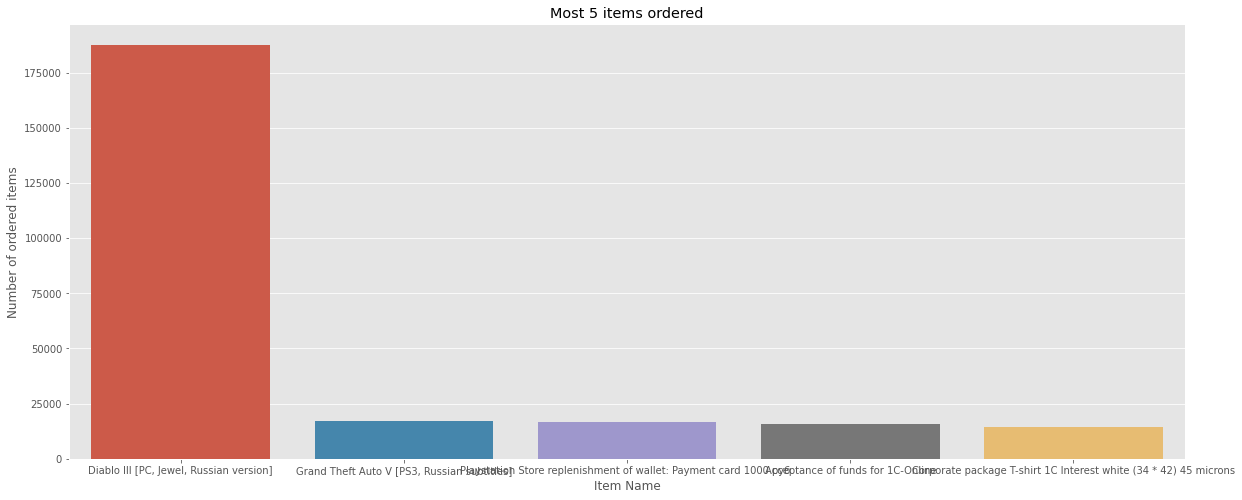

In [0]:
plt.figure(figsize = (20,8))
plt.title("Most 5 items ordered")
plt.xlabel("Item Name")
plt.ylabel("Number of ordered items")
sns.barplot(x = items_info.item_name_translated.values , y = best_5_items.values)

This is a big number compared to the other !

5) item_price

count    2935849.00
mean         890.85
std         1729.80
min           -1.00
25%          249.00
50%          399.00
75%          999.00
max       307980.00
Name: item_price, dtype: float64


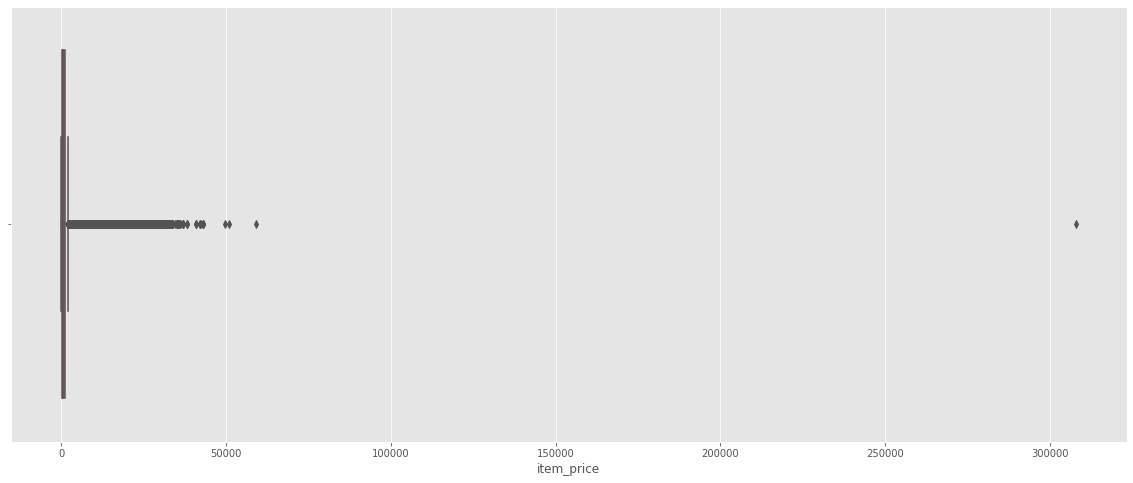

In [0]:
print(sales.item_price.describe().round(2))
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_price)

removing high and negative prices 

In [0]:
len(sales[sales.item_price > 25000] )/len(sales)

0.0007265956490103583

In [0]:
sales = sales[(sales.item_price > 0) & (sales.item_price <= 25000)]

count    2933475.00
mean         868.77
std         1536.25
min            0.07
25%          249.00
50%          399.00
75%          999.00
max        24999.00
Name: item_price, dtype: float64


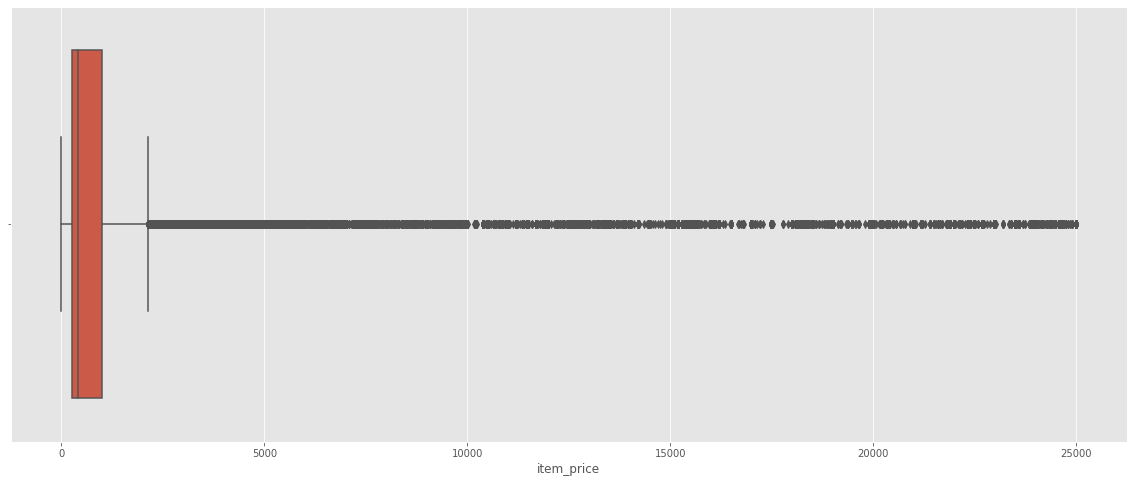

In [0]:
print(sales.item_price.describe().round(2))
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_price)

6) item_cnt_day (target variable):

count    2933475.0
mean           1.0
std            3.0
min          -22.0
25%            1.0
50%            1.0
75%            1.0
max         2169.0
Name: item_cnt_day, dtype: float64


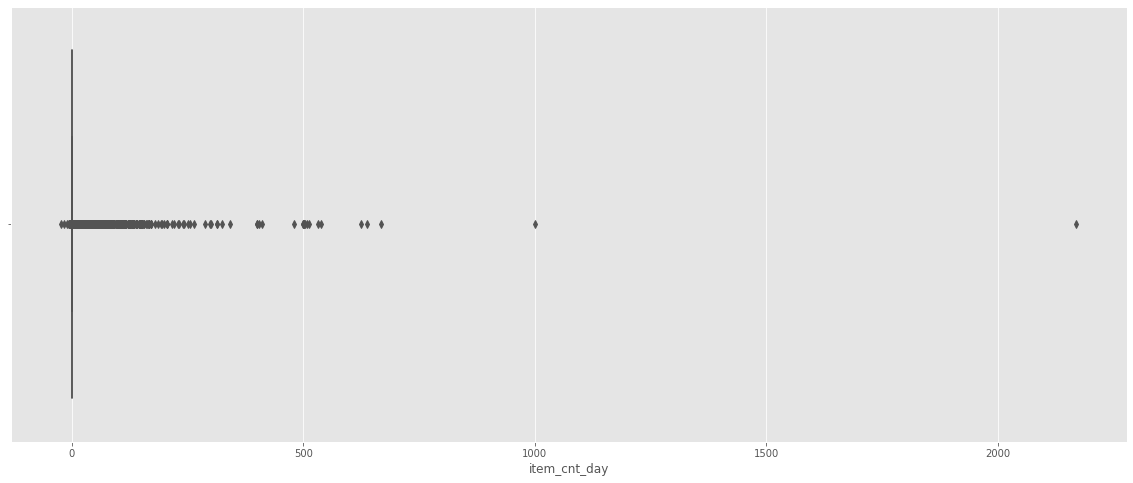

In [0]:
print(sales.item_cnt_day.describe().round())
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_cnt_day)

# Time series forcasting

# 1)Arima ( AutoRegressive Integrated Moving Average )

In [0]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales by month')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

There is a clear trend and seasonality in the data let's look in more details by making decomposition. It's an additive model as the frequency and amplitude is not changing over time.

In [0]:
decomp = sm.tsa.seasonal_decompose(ts.values , freq = 12 ,model = 'additive' )
fig = decomp.plot()

To use Arima the data must be stationary, i will make Augmented dicky fuller test to check stationarity there are other tests but this is the most popular.

In [0]:
def ADF_test(ts) :
    df_test = adfuller(ts , autolag = "AIC")
    df_output = pd.Series(df_test[0:4] , index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(df_output)

In [0]:
ADF_test(ts)

In [0]:
# create a differenced series
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert the series to the original scale
def inverse_difference(last_ob, value):
    return value + last_ob

In [0]:
stationary_ts = difference(ts)
ADF_test(stationary_ts)

The data is stationary now, only best parameter values left and arima has 3 parameters: (p, d, q). These three parameters account for seasonality, trend, and noise. plus another 3 parameters (P,D,Q) which are the same but for inserting the seasonaloity with us and using SARIMA.

In [0]:
p = d = q = range(0, 2) # taking values 0 , 1 , 2 respectively 
pdq = list(itertools.product(p, d, q)) #combine them in a list
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] #seasonal parameters will take all combinations of (0,1,2) 
# 12 is the time spane of repeating the seasonal pattern it could be differnt but i just choosed to make it 12 for simplicity

In [0]:
# I will use grid search to find the optimal set of parameters
aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(stationary_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit()
            aic.append(results.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print(min(aic))

(0, 1, 1)x(1, 1, 0, 12)12 are best paramaters with the least aic score 432.9178807849364 Let's do it ...

In [0]:
stationary_train = stationary_ts[0:27]
stationary_test = stationary_ts[27:33]
print('train: \n', stationary_train , '\n\n')
print('test: \n', stationary_test)

In [0]:
# Fit the model on the stationary_train set
mod = sm.tsa.statespace.SARIMAX(stationary_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12))
results = mod.fit()


We should always run model diagnostics to investigate any unusual behavior

In [0]:
fig = results.plot_diagnostics(figsize=(15, 12))
diagnostigs = fig

diagnostics is not bad so we are good and continue

In [0]:
yhat = results.predict(28, 33).tolist() # Predicting based on the stationary data
test = ts[28:34].tolist() # cinverting ti list to loop through it
yhat = [inverse_difference(test[i], yhat[i]) for i in range(len(yhat))]
yhat = pd.Series(yhat , index = ts[28:34].index) # converting it from list to a series to get the index 

In [0]:
plt.figure(figsize = (12,6))
plt.plot(ts[0:28] , label='Train')
plt.plot(ts[28:34] , label='Test')
plt.plot(yhat , label='six-months ahead Forecast')
plt.xlabel('Date block num')
plt.ylabel('number of items sold')
plt.legend()
plt.show()
rmse = sqrt(mean_squared_error(ts[28:34],yhat))
print('RMSE: %.1f' % rmse , "\n")
print(ts.describe()[1:3].round())

# Machine Learning

# Starting with a base model

In [0]:
# Getting ready for the base model
sales.date = pd.to_datetime(sales.date)
sales['year'] = sales.date.dt.year

base = sales.copy() # leaving the original dataset untouched
base = pd.DataFrame(base.groupby(['date_block_num','shop_id','year','item_id'])['item_cnt_day'].sum())
base = base.reset_index() 
base = base.rename(columns = {'item_cnt_day':'item_cnt_month'})
base

,date_block_num,shop_id,year,item_id,item_cnt_month
0,0,0,2013,32,6.0
1,0,0,2013,33,3.0
2,0,0,2013,35,1.0
3,0,0,2013,43,1.0
4,0,0,2013,51,2.0
...,...,...,...,...,...
1608223,33,59,2015,22087,6.0
1608224,33,59,2015,22088,2.0
1608225,33,59,2015,22091,1.0
1608226,33,59,2015,22100,1.0


In [0]:
def get_data_splits(df , split_fraction = 0.11) :
    """
    Splits a dataframe into 90% train, 10% validation but first order by the date_block_num. 
    
    """
    df = df.sort_values(by = 'date_block_num') #sort values by the date_clock_num so that the test set is the last period of time
    num_of_rows = int(len(df) * split_fraction)
    train = df[ :-num_of_rows ]
    validation = df[-num_of_rows : ]
    
    return train, validation

In [0]:
train, validation = get_data_splits(base)

In [0]:
validation

,date_block_num,shop_id,year,item_id,item_cnt_month
1427274,28,25,2015,12286,1.0
1427273,28,25,2015,12241,1.0
1427272,28,25,2015,12232,1.0
1427271,28,25,2015,12231,1.0
1427270,28,25,2015,12212,1.0
...,...,...,...,...,...
1588096,33,24,2015,9355,3.0
1588095,33,24,2015,9337,1.0
1588094,33,24,2015,8743,1.0
1588092,33,24,2015,8737,2.0


In [0]:

X_train = train.drop('item_cnt_month' , axis = 1)
y_train = train.item_cnt_month

X_val = validation.drop('item_cnt_month' , axis = 1)
y_val = validation.item_cnt_month


models = []
models.append(('XGB' , XGBRegressor(n_jobs= -1 , random_state= 1 ,random_state = random_state)) )
models.append(('RF' ,RandomForestRegressor(verbose = False ,random_state = 1) ))
models.append(('LR' ,LinearRegression() ))
for name, model in models :
    model.fit(X_train, y_train)
    rmse = sqrt( mean_squared_error(model.predict(X_val), y_val ) ) 
    print(name ,": ",rmse )


[12:16:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB :  10.595643104027445


In [0]:
# These are the values of the base model and will be improved after every part in the notebook
XGB :  7.175706496337836
RF :  8.50106502627325
LR :  8.036103975520204

In [0]:
# i want to insert in the first position the date_block_num to match the test with the train
test.insert(0 , 'date_block_num' , [34 for i in range(0, len(test) )])
test = test.drop('ID' , axis= 1)
test['year'] = 2015
test

,date_block_num,shop_id,item_id,year
0,34,5,5037,2015
1,34,5,5320,2015
2,34,5,5233,2015
3,34,5,5232,2015
4,34,5,5268,2015
...,...,...,...,...
214195,34,45,18454,2015
214196,34,45,16188,2015
214197,34,45,15757,2015
214198,34,45,19648,2015


In [0]:
# submitting to the leaderboard
xgb = XGBRegressor(verbose = False , ,random_state = random_state)
xgb.fit(base.drop('item_cnt_month',axis = 1), base.item_cnt_month)
preds_xgb = xgb.predict(test)
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('sub.csv' , index = False)

I got about 6 RMSE with the base model

# Feature Engineering

In [0]:
sales1 = base.copy() # Continue on the base model

In [0]:
# what is the portion of data that has target variable value with more than 20
round((len(base[base.item_cnt_month > 20]) / len(base)),3)


item_cnt_day has natural ouliers with values more than 20 and although they represent the real life but they are not a lot and make a lot of niose to the model so i will trim any value more than 20 and we will lose a small fraction of the data anyways



count    1596797.0
mean           2.0
std            2.0
min          -22.0
25%            1.0
50%            1.0
75%            2.0
max           20.0
Name: item_cnt_month, dtype: float64


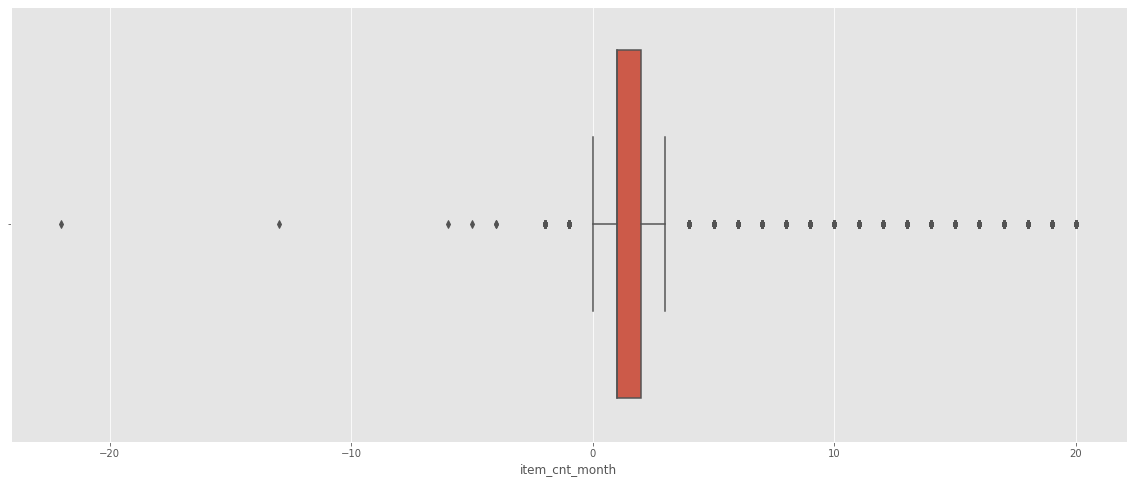

In [0]:
sales1 = sales1[sales1.item_cnt_month <= 20]
print(sales1.item_cnt_month.describe().round())
plt.figure(figsize = (20 , 8))
sns.boxplot(sales1.item_cnt_month)
plt.show()

In [0]:
# how many value in the target variable less than zero
print(len(sales1[sales1.item_cnt_month < 0 ]))
print(len(sales1[sales1.item_cnt_month < 0 ]) / len(sales1))

915
0.000572767443272549


I will remove the negative values as they will cause noise on the data

In [0]:
sales1 = sales1[sales1.item_cnt_month > 0]

Testing the model performance after trimming all values greater than 20 and less than 0

In [0]:
# Validating after trimming the target variabel
train, validation = get_data_splits(sales1)
X_train = train.drop('item_cnt_month' , axis = 1)
y_train = train.item_cnt_month

X_val = validation.drop('item_cnt_month' , axis = 1)
y_val = validation.item_cnt_month


models = []
models.append(('XGB' , XGBRegressor(n_jobs= -1 , random_state = random_state)) )
models.append(('tree' ,DecisionTreeRegressor( random_state = random_state) ))
for name, model in models :
    model.fit(X_train, y_train)
    rmse = sqrt( mean_squared_error(model.predict(X_val), y_val ) ) 
    print(name ,": ",rmse )

[22:05:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB :  1.8107339608258164
tree :  2.200290557105213


In [0]:
XGB :  1.8107339608258164
tree :  2.200290557105213

Trimming the target variable improved the performance a lot on the validation data

refitting on the full data and see the impact

In [0]:
xgb = XGBRegressor(verbose = False , n_jobs = -1 , random_state = random_state)
xgb.fit(sales1.drop(['item_cnt_month'],axis = 1), sales1.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'xgb_after_trimming.sav'
pickle.dump(xgb , open(file_name, 'wb'))


[22:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
# submitting in the leaderboard
#xgb = pickle.load(open('/content/xgb_after_trimming.sav', 'rb'))
test = test[sales1.drop('item_cnt_month',axis = 1).columns] # sorting column names in the same order
preds = xgb.predict(test)
sub = sample_submission
sub.item_cnt_month = preds
sub.to_csv('xgb_after_trimming.csv' , index = False)

In [0]:
sales1.to_csv('sales1.csv' , index = False)
test.to_csv('test.csv',index = False)

In [0]:
# reading the sales file
sales1 = pd.read_csv('/content/sales1.csv')
test = pd.read_csv('/content/test.csv')

# Mean Encoding

`Motivation` : the item_id is not ordinal and if we one hot encoded it we will fall in the curse of dimensionality hence mean encoding is needed to solve this trap.

In [0]:
from itertools import product # to make cartisien product
index_cols = ['shop_id' , 'item_id' , 'date_block_num']
grid = []
for block_num in sales.date_block_num.unique() : # iterating over the 34 month
    curr_shops = sales[sales.date_block_num == block_num]['shop_id'].unique() # get the unique shops in this month
    curr_items = sales[sales.date_block_num == block_num]['item_id'].unique() # get the unique items in this month
    grid.append(np.array(list(product (*[ curr_shops, curr_items, [block_num]]))))
grid = pd.DataFrame(np.vstack(grid) , columns = index_cols ) 
all_data = grid.merge(sales1[['shop_id' , 'item_id' , 'date_block_num','item_cnt_month']] , how = 'left' , on = index_cols).sort_values(index_cols).fillna(0) #to add the item_cnt_month
all_data

,shop_id,item_id,date_block_num,item_cnt_month
606857,0,12,1,0.0
139255,0,19,0,0.0
141495,0,27,0,0.0
606011,0,27,1,0.0
144968,0,28,0,0.0
...,...,...,...,...
5954,59,22168,0,0.0
442338,59,22168,1,0.0
1104387,59,22168,2,0.0
3339542,59,22168,8,0.0


In [0]:
def downcasting(df) :
    """
    make 2 lists onc contains index of float64 columns and the other int64 or int32,
    then change the dtype of these column into less memory consumer data type
    """
    float_cols = [ col for col in df if df[col].dtype == "float64" ]
    int_cols = [col for col in df if df[col].dtype in ['int64','int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [0]:
# reducing memory usage
all_data = downcasting(all_data)
all_data.item_cnt_month = all_data.item_cnt_month.astype('int16')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 606857 to 5255652
Data columns (total 4 columns):
 #   Column          Dtype
---  ------          -----
 0   shop_id         int16
 1   item_id         int16
 2   date_block_num  int16
 3   item_cnt_month  int16
dtypes: int16(4)
memory usage: 166.5 MB


adding category_id to mean encode it

In [0]:
# for each item_id put the item_category_id
all_data = all_data.merge(items[['item_id','item_category_id']] ) 
test = test.merge(items[['item_id','item_category_id']])
all_data

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_target_enc,category_target_enc,shop_target_enc
0,0,12,1,0,55,0.277068,0.244224,0.542470
1,1,12,1,0,55,0.277068,0.244224,0.331652
2,2,12,1,0,55,0.277068,0.244224,0.108152
3,3,12,1,0,55,0.277068,0.244224,0.105209
4,4,12,1,0,55,0.277068,0.244224,0.147489
...,...,...,...,...,...,...,...,...
10913845,55,22169,14,0,69,0.277068,0.176874,0.171766
10913846,56,22169,14,0,69,0.277068,0.176874,0.301092
10913847,57,22169,14,0,69,0.277068,0.176874,0.521881
10913848,58,22169,14,0,69,0.277068,0.176874,0.323199


In [0]:
all_data.isna().sum() # no nulls and every thing is right

shop_id             0
item_id             0
date_block_num      0
item_cnt_month      0
item_category_id    0
item_price          0
dtype: int64

Working with regularized mean encoding in order to decrease the leakage

In [0]:
# encoding item_id
kf = KFold(n_splits = 5 , shuffle = False)
for train_ind, val_ind in kf.split(all_data) :
    train_data , val_data = all_data.iloc[train_ind], all_data.iloc[val_ind]
    all_data.loc[all_data.index[val_ind] , 'item_target_enc'] = val_data['item_id'].map(train_data.groupby('item_id')['item_cnt_month'].mean())
    
all_data['item_target_enc'].fillna(all_data.item_cnt_month.mean(), inplace=True) # fill na that happend from values in validation not in the train with the global mean    

In [0]:
# making a column to map it to the test set
item_mean_enc = all_data.groupby('item_id')['item_target_enc'].unique()
item_mean_enc = item_mean_enc.apply(lambda x: x.mean())

test['item_target_enc'] = test['item_id'].map(item_mean_enc) # mapping the variable in the test 
test.fillna(all_data.item_cnt_month.mean() , inplace = True)
test

,date_block_num,item_id,shop_id,year,item_category_id,item_target_enc
0,34,5037,5,2015,19,0.277068
1,34,5037,4,2015,19,0.277068
2,34,5037,6,2015,19,0.277068
3,34,5037,3,2015,19,0.277068
4,34,5037,2,2015,19,0.277068
...,...,...,...,...,...,...
214195,34,969,46,2015,37,0.277068
214196,34,969,41,2015,37,0.277068
214197,34,969,44,2015,37,0.277068
214198,34,969,39,2015,37,0.277068


In [0]:
# encoding item_category_id
kf = KFold(n_splits = 5 , shuffle = False)
for train_ind, val_ind in kf.split(all_data) :
    train_data , val_data = all_data.iloc[train_ind], all_data.iloc[val_ind]
    all_data.loc[all_data.index[val_ind] , 'category_target_enc'] = val_data['item_category_id'].map(train_data.groupby('item_category_id')['item_cnt_month'].mean())
    
all_data['category_target_enc'].fillna(all_data.item_cnt_month.mean(), inplace=True) # fill na that happend from values in validation not in the train with the global mean    

In [0]:
# making a column to map it to the test set
category_mean_enc = all_data.groupby('item_category_id')['category_target_enc'].unique()
category_mean_enc = category_mean_enc.apply(lambda x: x.mean())

test['category_target_enc'] = test['item_category_id'].map(category_mean_enc) # mapping the variable in the test 
test.fillna(all_data.item_cnt_month.mean() , inplace = True)
test

,date_block_num,item_id,shop_id,year,item_category_id,item_target_enc,category_target_enc
0,34,5037,5,2015,19,0.277068,0.654430
1,34,5037,4,2015,19,0.277068,0.654430
2,34,5037,6,2015,19,0.277068,0.654430
3,34,5037,3,2015,19,0.277068,0.654430
4,34,5037,2,2015,19,0.277068,0.654430
...,...,...,...,...,...,...,...
214195,34,969,46,2015,37,0.277068,0.173617
214196,34,969,41,2015,37,0.277068,0.173617
214197,34,969,44,2015,37,0.277068,0.173617
214198,34,969,39,2015,37,0.277068,0.173617


encoding shop id

In [0]:
# encoding item_category_id
kf = KFold(n_splits = 5 , shuffle = False)
for train_ind, val_ind in kf.split(all_data) :
    train_data , val_data = all_data.iloc[train_ind], all_data.iloc[val_ind]
    all_data.loc[all_data.index[val_ind] , 'shop_target_enc'] = val_data['shop_id'].map(train_data.groupby('shop_id')['item_cnt_month'].mean())
    
all_data['shop_target_enc'].fillna(all_data.item_cnt_month.mean(), inplace=True) # fill na that happend from values in validation not in the train with the global mean    

In [0]:
# making a column to map it to the test set
shop_mean_enc = all_data.groupby('shop_id')['shop_target_enc'].unique()
shop_mean_enc = shop_mean_enc.apply(lambda x: x.mean())

test['shop_target_enc'] = test['shop_id'].map(shop_mean_enc) # mapping the variable in the test 
test.fillna(all_data.item_cnt_month.mean() , inplace = True)
test

,date_block_num,item_id,shop_id,year,item_category_id,item_target_enc,category_target_enc,shop_target_enc
0,34,5037,5,2015,19,0.277068,0.654430,0.173480
1,34,5037,4,2015,19,0.277068,0.654430,0.167921
2,34,5037,6,2015,19,0.277068,0.654430,0.360782
3,34,5037,3,2015,19,0.277068,0.654430,0.112695
4,34,5037,2,2015,19,0.277068,0.654430,0.115980
...,...,...,...,...,...,...,...,...
214195,34,969,46,2015,37,0.277068,0.173617,0.292687
214196,34,969,41,2015,37,0.277068,0.173617,0.188659
214197,34,969,44,2015,37,0.277068,0.173617,0.176294
214198,34,969,39,2015,37,0.277068,0.173617,0.114884


seeing the impact of mean encoding

In [0]:
test.head(1)

,ID,shop_id,item_id,item_category_id,item_target_enc,category_target_enc,shop_target_enc
0,0,5,5037,19,0.277068,0.65443,0.17348


In [0]:
all_data.head(1)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_target_enc,category_target_enc,shop_target_enc
0,0,12,1,0,55,0.277068,0.244224,0.54247


In [0]:
xgb = XGBRegressor(verbose = False , n_jobs = -1 ,random_state = random_state)
xgb.fit(all_data.drop(['item_cnt_month','item_id','item_category_id'],axis = 1), all_data.item_cnt_month)

#saving the model in order to run it again witout taking so much time
file_name = 'xgb_mean_encoding_with_shop_id.sav'
pickle.dump(xgb , open(file_name, 'wb'))

# submitting in the leaderboard
#xgb = pickle.load(open('', 'rb'))
test = test[all_data.drop('item_cnt_month',axis = 1).columns]
preds_xgb = xgb.predict(test.drop(['item_id','item_category_id'],axis = 1))
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('xgb_mean_encoding_with_shop_id.csv' , index = False)

The Error deacresed from `1.85026` to `1.23868`

Mean encodnig improved the model performance a lot

working with the price 

In [0]:
item_prices = pd.DataFrame(sales.groupby('item_id')['item_price'].unique()).reset_index()
item_prices

There are different prices for the same item so we need to take the average to reduce the varianece and enforce consistancy


In [0]:
# for each item get its mean price
mean_prices = pd.DataFrame(sales.groupby('item_id')['item_price'].mean()).reset_index()
mean_prices

,item_id,item_price
0,0,58.000000
1,1,4490.000000
2,2,58.000000
3,3,79.000000
4,4,58.000000
...,...,...
21802,22165,59.000000
21803,22166,150.000000
21804,22167,297.686490
21805,22168,798.916667


In [0]:
all_data = all_data.merge(mean_prices)
all_data = all_data.rename(columns= {'item_price': 'mean_price'})
all_data.mean_price = round(all_data.mean_price , 2)

In [0]:
test = test.merge(mean_prices,how = 'left' ) # mapping the price for each item by merging on the item_id
test = test.rename(columns = {'item_price':'mean_price'})
test.mean_price = round(test.mean_price , 2)
test

,shop_id,item_id,date_block_num,item_category_id,item_target_enc,category_target_enc,shop_target_enc,mean_price
0,5,5037,34,19,0.277068,0.654430,0.173480,1926.83
1,4,5037,34,19,0.277068,0.654430,0.167921,1926.83
2,6,5037,34,19,0.277068,0.654430,0.360782,1926.83
3,3,5037,34,19,0.277068,0.654430,0.112695,1926.83
4,2,5037,34,19,0.277068,0.654430,0.115980,1926.83
...,...,...,...,...,...,...,...,...
214195,46,969,34,37,0.277068,0.173617,0.292687,502.30
214196,41,969,34,37,0.277068,0.173617,0.188659,502.30
214197,44,969,34,37,0.277068,0.173617,0.176294,502.30
214198,39,969,34,37,0.277068,0.173617,0.114884,502.30


In [0]:
test.isna().sum()

date_block_num             0
shop_id                    0
item_id                    0
year                       0
item_category_id           0
item_target_enc            0
category_target_enc        0
mean_price             15372
dtype: int64

In [0]:
len([i for i in test.item_id.unique() if i not in sales.item_id.unique()])

366

In [0]:
test.item_id.nunique()

5100

there are `366` out of `5100` unique test item_id not in the train data so i will impute them with the category_id_mean_price

In [0]:
# for each category get its mean price
category_mean_prices = pd.DataFrame(all_data.groupby('item_category_id')['mean_price'].mean()).reset_index()
category_mean_prices

,item_category_id,mean_price
0,0,87.360584
1,1,216.241758
2,2,2376.713047
3,3,1689.994049
4,4,488.529793
...,...,...
79,79,1094.630000
80,80,1227.256667
81,81,247.967597
82,82,34.450027


In [0]:
missing_cat = [i for i in test.item_category_id.unique() if i not in category_mean_prices.item_category_id.unique()]
missing_cat

[]

In [0]:
dic = {}
for i in category_mean_prices.item_category_id.unique() :
  dic[i] =category_mean_prices[category_mean_prices.item_category_id == i]['mean_price'].values[0]

for i in  missing_cat :
  dic[i] = all_data.mean_price.mean() #fill with the global mean

In [0]:
ind = test[test.mean_price.isna()].index
for i in ind :
  test.loc[i , 'mean_price'] = dic[test.loc[i , 'item_category_id']]

In [0]:
xgb = XGBRegressor(verbose = False , n_jobs = -1 ,random_state = random_state)
xgb.fit(all_data.drop(['item_cnt_month','item_id','item_category_id'],axis = 1), all_data.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'xgb_mean_encoding_with_price.sav'
pickle.dump(xgb , open(file_name, 'wb'))

# submitting in the leaderboard
#xgb = pickle.load(open('', 'rb'))
preds_xgb = xgb.predict(test.drop(['item_id','item_category_id'],axis = 1))
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('xgb_mean_encoding_with_price.csv' , index = False)

[22:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:07] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


Accuracy is the same

adding the year

In [0]:
all_data['year'] = all_data['date_block_num'].map(lambda x : 2013 if x < 12 else 2014 if x < 24 else 2015)
test['year'] = 2015
all_data

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_target_enc,category_target_enc,shop_target_enc,mean_price,year
0,0,12,1,0,55,0.277068,0.244224,0.542470,189.0,2013
1,1,12,1,0,55,0.277068,0.244224,0.331652,189.0,2013
2,2,12,1,0,55,0.277068,0.244224,0.108152,189.0,2013
3,3,12,1,0,55,0.277068,0.244224,0.105209,189.0,2013
4,4,12,1,0,55,0.277068,0.244224,0.147489,189.0,2013
...,...,...,...,...,...,...,...,...,...,...
10913845,55,22169,14,0,69,0.277068,0.176874,0.171766,4349.0,2014
10913846,56,22169,14,0,69,0.277068,0.176874,0.301092,4349.0,2014
10913847,57,22169,14,0,69,0.277068,0.176874,0.521881,4349.0,2014
10913848,58,22169,14,0,69,0.277068,0.176874,0.323199,4349.0,2014


In [0]:
all_data = downcasting(all_data) # reducing memory usage
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   shop_id              int16  
 1   item_id              int16  
 2   date_block_num       int16  
 3   item_cnt_month       int16  
 4   item_category_id     int16  
 5   item_target_enc      float32
 6   category_target_enc  float32
 7   shop_target_enc      float32
 8   mean_price           float32
 9   year                 int16  
dtypes: float32(4), int16(6)
memory usage: 374.7 MB


# Adding lags

In [0]:
# train lags with
lag_list = [1, 2, 3 ]

for lag in lag_list:
    ft_name = ('item_cnt_month_shifted%s' % lag)
    all_data[ft_name] = all_data.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt_month'].shift(lag)
    # Fill the empty shifted features with 0
    all_data[ft_name].fillna(0, inplace=True)

In [0]:
all_data_lags[all_data_lags.item_id ==13881 ].sort_values(['date_block_num','shop_id']).tail(60)

In [0]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int16  
 1   item_id                  int16  
 2   date_block_num           int16  
 3   item_cnt_month           int16  
 4   item_category_id         int16  
 5   item_target_enc          float32
 6   category_target_enc      float32
 7   shop_target_enc          float32
 8   mean_price               float32
 9   year                     int16  
 10  item_cnt_month_shifted1  float64
 11  item_cnt_month_shifted2  float64
 12  item_cnt_month_shifted3  float64
dtypes: float32(4), float64(3), int16(6)
memory usage: 624.5 MB


In [0]:
all_data.item_cnt_month_shifted1  = all_data.item_cnt_month_shifted1.astype('int8')
all_data.item_cnt_month_shifted2  = all_data.item_cnt_month_shifted2.astype('int8')
all_data.item_cnt_month_shifted3  = all_data.item_cnt_month_shifted3.astype('int8')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int16  
 1   item_id                  int16  
 2   date_block_num           int16  
 3   item_cnt_month           int16  
 4   item_category_id         int16  
 5   item_target_enc          float32
 6   category_target_enc      float32
 7   shop_target_enc          float32
 8   mean_price               float32
 9   year                     int16  
 10  item_cnt_month_shifted1  int8   
 11  item_cnt_month_shifted2  int8   
 12  item_cnt_month_shifted3  int8   
dtypes: float32(4), int16(6), int8(3)
memory usage: 405.9 MB


the memory usage is reduced to the half

adding the lags to the test data

In [0]:
def get_test_lags(all_data , test, lag) :
    
    shifted = all_data[['date_block_num','shop_id','item_id', 'item_cnt_month']]
    shifted.columns = ['date_block_num','shop_id','item_id', 'item_cnt_month_shifted'+ str(lag)]
    shifted['date_block_num'] -= lag
    test_lag = pd.merge(test, shifted, on=['date_block_num','shop_id','item_id'] , how = 'left')
    return test_lag['item_cnt_month_shifted'+ str(lag)] #return the last column (the lags) 

In [0]:
test_lags = test.copy()
for lag in range(1,4):
    lag_values = get_test_lags(all_data ,test, lag)
    test_lags['item_cnt_month_shifted'+ str(lag)] = lag_values
test_lags.fillna(0 , inplace = True)    

from `1.238` to`1.230` 

In [0]:
all_data_l = all_data.copy()
all_data_l['date_block_num'] += 1
test_lags1 = test.merge(all_data_l[['date_block_num','shop_id','item_id', 'item_cnt_month','item_cnt_month_shifted1','item_cnt_month_shifted2']] , how = 'left' , on =['date_block_num', 'item_id','shop_id'] )
test_lags1 = test_lags1.rename(columns = {'item_cnt_month':'item_cnt_month_shifted1' , 'item_cnt_month_shifted1':'item_cnt_month_shifted2','itemm_cnt_month_shifted2':'itemm_cnt_month_shifted3'})

In [0]:
test_lags1.fillna(0 , inplace = True)

testing the lags impact

In [0]:
xgb = XGBRegressor(verbose = False , n_jobs = -1,random_state = random_state)
xgb.fit(all_data.drop(['item_cnt_month','item_id','item_category_id','mean_price'],axis = 1), all_data.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'xgb_adding_lags.sav'
pickle.dump(xgb , open(file_name, 'wb'))


[00:58:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:58:15] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [0]:
# submitting in the leaderboard
#xgb = pickle.load(open('', 'rb'))
test_lags = test_lags[all_data.drop('item_cnt_month' , axis = 1).columns]
preds_xgb = xgb.predict(test_lags.drop(['item_id','item_category_id','mean_price'],axis = 1))
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('xgb_adding_lags7.csv' , index = False)

adding item category name

In [0]:
all_data = all_data.merge(item_categories) # getting the item_category_name
test = test_lags.merge(item_categories) # getting the item_category_name 

adding main category and subcategory

In [0]:
all_data['main_category'] = all_data.item_category_name_translated.str.split('-').map(lambda x: x[0].strip()) 
all_data['sub_category'] = all_data.item_category_name_translated.str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [0]:
test['main_category'] = test.item_category_name_translated.str.split('-').map(lambda x: x[0].strip()) 
test['sub_category'] = test.item_category_name_translated.str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [0]:
shops.shop_name_translated.unique()[:10]

array(['Yakutsk Ordzhonikidze, 56 francs', 'Yakutsk TC "Central" franc',
       'Adygea Shopping Center "Mega"',
       'Balashikha TRK "October-Kinomir"',
       'Volzhsky shopping center "Volga Mall"',
       'Vologda Shopping and Entertainment Center "Marmalade"',
       'Voronezh (Plekhanovskaya, 13)', 'Voronezh TRC "Maksimir"',
       'Voronezh TRC City-Park "Grad"', 'Outbound Trade'], dtype=object)

the start of every shop_name is a city

In [0]:
all_data = all_data.merge(shops) #adding shop_name
all_data['city'] = all_data.shop_name_translated.str.split(' ').map(lambda x : x[0]) #the first word is a city name
all_data

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_target_enc,category_target_enc,shop_target_enc,mean_price,year,item_cnt_month_shifted1,item_cnt_month_shifted2,item_cnt_month_shifted3,item_category_name_translated,main_category,sub_category,shop_name_translated,city
0,0,12,1,0,55,0.277068,0.244224,0.542470,189.000000,2013,0,0,0,Music - CD of local production,Music,CD of local production,"Yakutsk Ordzhonikidze, 56 francs",Yakutsk
1,0,970,0,0,55,0.277068,0.244224,0.542470,301.200012,2013,0,0,0,Music - CD of local production,Music,CD of local production,"Yakutsk Ordzhonikidze, 56 francs",Yakutsk
2,0,970,1,1,55,0.277068,0.244224,0.542470,301.200012,2013,0,0,0,Music - CD of local production,Music,CD of local production,"Yakutsk Ordzhonikidze, 56 francs",Yakutsk
3,0,971,0,0,55,0.277068,0.244224,0.542470,308.209991,2013,0,0,0,Music - CD of local production,Music,CD of local production,"Yakutsk Ordzhonikidze, 56 francs",Yakutsk
4,0,971,1,1,55,0.277068,0.244224,0.542470,308.209991,2013,0,0,0,Music - CD of local production,Music,CD of local production,"Yakutsk Ordzhonikidze, 56 francs",Yakutsk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913845,58,16835,26,0,50,0.277068,0.277068,0.323199,24.000000,2015,0,0,0,Books - Postcards,Books,Postcards,Yakutsk Central shopping center,Yakutsk
10913846,58,17703,18,0,51,0.277068,0.277068,0.323199,129.000000,2014,0,0,0,Books - Cognitive Literature,Books,Cognitive Literature,Yakutsk Central shopping center,Yakutsk
10913847,58,19700,11,0,53,0.277068,0.277068,0.323199,299.000000,2013,0,0,0,Books - Fiction,Books,Fiction,Yakutsk Central shopping center,Yakutsk
10913848,58,19701,13,0,53,0.277068,0.277068,0.323199,349.000000,2014,0,0,0,Books - Fiction,Books,Fiction,Yakutsk Central shopping center,Yakutsk


In [0]:
test = test.merge(shops) #adding shop_name
test['city'] = test.shop_name_translated.str.split(' ').map(lambda x : x[0]) #the first word is a city name

nothing else important in the shop_name or the item_category_name so i will remove them

mean encode the new three added variables

In [0]:
kf = KFold(n_splits = 5 , shuffle = False)
for train_ind, val_ind in kf.split(all_data) :
    train_data , val_data = all_data.iloc[train_ind], all_data.iloc[val_ind]
    all_data.loc[all_data.index[val_ind] , 'city_target_enc'] = val_data['city'].map(train_data.groupby('city')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'main_category_target_enc'] = val_data['main_category'].map(train_data.groupby('main_category')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'sub_category_target_enc'] = val_data['sub_category'].map(train_data.groupby('sub_category')['item_cnt_month'].mean())

all_data.fillna(all_data.item_cnt_month.mean(), inplace=True) # fill na that happend from values in validation not in the train with the global mean    


In [0]:
# making a column to map it to the test set
city_mean_enc = all_data.groupby('city')['city_target_enc'].unique()
city_mean_enc = city_mean_enc.apply(lambda x: x.mean())
test['city_target_enc'] = test['city'].map(city_mean_enc) # mapping the variable in the test 

sub_category_mean_enc = all_data.groupby('sub_category')['sub_category_target_enc'].unique()
sub_category_mean_enc = sub_category_mean_enc.apply(lambda x: x.mean())
test['sub_category_target_enc'] = test['sub_category'].map(sub_category_mean_enc) # mapping the variable in the test 

main_category_mean_enc = all_data.groupby('main_category')['main_category_target_enc'].unique()
main_category_mean_enc = main_category_mean_enc.apply(lambda x: x.mean())
test['main_category_target_enc'] = test['main_category'].map(main_category_mean_enc) # mapping the variable in the test 

test.fillna(all_data.item_cnt_month.mean() , inplace = True)
test

In [0]:
all_data = downcasting(all_data)

In [0]:
all_data.shop_id = all_data.shop_id.astype('int8')
all_data.date_block_num = all_data.date_block_num.astype('int8')
all_data.item_cnt_month = all_data.item_cnt_month.astype('int8')
all_data.item_category_id = all_data.item_category_id.astype('int8')
all_data.year = all_data.year.astype('int8')

In [0]:
# keep a version of this data
all_data.to_csv('my_data.csv' , index = False)
test.to_csv('test.csv' , index = False)

In [0]:
# reading the data from the last stop point
all_data = pd.read_csv('')
test = pd.read_csv('')

In [0]:
all_data.drop(['shop_name_translated', 'item_category_name_translated'] , inplace = True , axis = 1)
test.drop(['shop_name_translated','item_category_name_translated'] , inplace = True , axis = 1)

adding interaction features with label encoding

In [0]:
import itertools
cat_features = ['shop_id','item_id','city' ,'main_category','sub_category','item_cnt_month_shifted1','item_cnt_month_shifted2','item_cnt_month_shifted3','mean_price']
# Iterate through each pair of 2 features, combine them into interaction features
all_combinations = list(itertools.combinations(cat_features, 2))
for combination in all_combinations: #for each pair of columns convert them to strings then join them with the + operator.
  interaction = all_data[combination[0]].map(str) + '_' + all_data[combination[1]].map(str)
  interaction_name = combination[0] + '_' + combination[1]

  all_data[interaction_name] = pd.factorize(interaction) # return the interaction column label encoded directly


In [0]:
for combination in all_combinations: #for each pair of columns convert them to strings then join them with the + operator.
  interaction = test[combination[0]].map(str) + '_' + test[combination[1]].map(str)
  interaction_name = combination[0] + '_' + combination[1]
  test[interaction_name] = pd.factorize(interaction) # return the interaction column label encoded directly


seeing the effect of the added features

In [0]:
xgb = XGBRegressor(verbose = False , n_jobs = -1,random_state = random_state)
xgb.fit(all_data.drop(['item_cnt_month','item_id','item_category_id','shop_id','city','main_category','sub_category'],axis = 1), all_data.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'xgball_features.sav'
pickle.dump(xgb , open(file_name, 'wb'))

In [0]:
# submitting in the leaderboard
#xgb = pickle.load(open('', 'rb'))
test_lags = test_lags[all_data.drop('item_cnt_month' , axis = 1).columns]
preds_xgb = xgb.predict(test_lags.drop(['item_id','item_category_id','shop_id','city','main_category','sub_category'],axis = 1))
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('xgball_features.csv' , index = False)

# Feature selection

In [0]:
results=pd.DataFrame()
results['columns']=X_train.columns
results['importances'] = xgb.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)
results.head(60)

In [0]:
train = all_data[all_data.date_block_num < 33]
val = all_data[all_data.date_block_num == 33] # taking the last month to simulate the test set

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_train = selection.transform(train)
	# train model
	selection_model = XGBRegressor()
	selection_model.fit(select_train.drop('item_cnt_month',axis = 1),select_train.item_cnt_month )
	# eval model
	select_val = selection.transform(val)
	predictions = selection_model.predict(select_val)
	RMSE = sqrt(mean_squared_error(val.item_cnt_month, predictions))
	print("Thresh=%.3f, n=%d, RMSE: %.2f%%" % (thresh, select_train.shape[1], RMSE))


In [0]:
results = results[results.importances > 0]
selected_cols = list(results['columns'].values)
Final_X_train = X_train[selected_cols]
Final_X_test = X_test[selected_cols]

In [0]:
plt.figure(figsize=(20,8))
plt.title("Features importance based on f1 score")
plt.xlabel("features")
plt.ylabel("inportance")
sns.barplot(x = results['features'] , y = results['importance'] )

In [0]:
plt.figure(figsize=(20,8))
plot_importance(xgb)
plt.show()

# hyper paramter tuning

we will not be able to do cross validation of grid search as it's time based data 

# Model Explainability with shap values

# Trying Ensamble technique to increase the accuracy